# Module 1 - Resampling and masking WaPOR climate data (RET & PCP)
This Notebook contains the following steps
* Step a - Import modules/libraries
* Step b - Resampling raster data
* Step c - Clip to boundary (using shapefile)
* Step d - Calculate seasonal PCP and RET data
* Step e - Calculating potential ET (optional for IPA - adequacy)

**=====================================================================================================================**

![title](https://raw.githubusercontent.com/wateraccounting/WAPORWP/master/Notebooks/img/Fig1_1.png)

**=====================================================================================================================**

Before you start running this Notebook, make sure you have the following information:

*   WaPOR Reference ET and PCP for your case study for the period you want to do the analyses. Use this script for downloading the data: [Downloading_WaPORv3_data script](https://github.com/wateraccounting/WaPORMOOC/tree/main/1_WaPOR_download_colab). *For small areas make sure you download the data using a bounding box to avoid non data*

*   Sample of a TIFF file with the resolution you want to do the analyses
*   Shapefile of the area of interest (AOI)
*   Optional: land cover classification (LCC) map if you want to mask out certain land use classes. In the example case, we downloaded the WaPORv2 L2 LCC map for the area [provided on github](https://github.com/wateraccounting/WaPORIPA/blob/main/data/Wad_Helal_LCC.tif)


## Step 1a - Import modules/libraries

In [ ]:
!pip install --upgrade rioxarray --quiet

In [44]:
import os                             # a module for interacting with the operating system
import glob                           # used to retrieve files/pathnames matching a specified pattern
import matplotlib.pyplot as plt       # is a plotting library used for 2D graphics in python
import numpy as np                    # stands for 'Numerical Python, is a python library used for scientific computing with arrays
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as rioxr
import rasterio as rio
import pandas as pd                       # to store and manipulate tabular data in rows of observations and columns of variables
import calendar
import datetime

from osgeo import ogr, gdal
import subprocess


To import some useful GISfunctions, zip the Modules folder from github and upload it here.

In [2]:
#To upload modules.zip (importing GISfunctions to do the calculations).
from google.colab import files
uploaded = files.upload()

Saving Modules.zip to Modules.zip


In [3]:
# unzip the uploaded zipfile
!unzip '/content/Modules.zip' -d '/content/'

Archive:  /content/Modules.zip
   creating: /content/Modules/
   creating: /content/Modules/GIS_functions/
  inflating: /content/Modules/GIS_functions/GIS_function.py  
 extracting: /content/Modules/GIS_functions/__init__.py  
   creating: /content/Modules/GIS_functions/__pycache__/
  inflating: /content/Modules/GIS_functions/__pycache__/GIS_function.cpython-37.pyc  
  inflating: /content/Modules/GIS_functions/__pycache__/__init__.cpython-37.pyc  
   creating: /content/Modules/WaPOR/
  inflating: /content/Modules/WaPOR/GIS_functions.py  
  inflating: /content/Modules/WaPOR/WaitbarConsole.py  
  inflating: /content/Modules/WaPOR/WaporAPI.py  
  inflating: /content/Modules/WaPOR/__init__.py  
  inflating: /content/Modules/WaPOR/__init__.pyc  
   creating: /content/Modules/WaPOR/__pycache__/
  inflating: /content/Modules/WaPOR/__pycache__/AET_dekadal.cpython-36.pyc  
  inflating: /content/Modules/WaPOR/__pycache__/AET_dekadal.cpython-37.pyc  
  inflating: /content/Modules/WaPOR/__pycache_

In [4]:
os.chdir(os.path.join(os.path.split(os.getcwd())[0], "/content/Modules"))
from GIS_functions import GIS_function as gis

Changing directory back to main directory

In [9]:
os.chdir(os.path.join(os.path.split(os.getcwd())[0], "/content"))

# Step 1b - Resample raster data

After downloading RET and PCP using [Downloading_WaPORv3_data script](https://github.com/wateraccounting/WaPORMOOC/tree/main/1_WaPOR_download_colab), the data needs to be resampled to the same resolution as the NPP and AETI data. You need an example file (TIFF file) with this resolution at hand (if you call the file 'sample_res.tif' the script will run without changing file names).

*Download using bounding box (bb) not shapefile to avoid empty data.*

## Import the input data and sample of resolution

Import downloaded RET and PCP files

In [10]:
#To upload data.zip.
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [11]:

# unzip the uploaded zipfile
!unzip '/content/data.zip' -d '/content/'

Archive:  /content/data.zip
   creating: /content/content/output/
   creating: /content/content/output/L1-RET-E/
  inflating: /content/content/output/L1-RET-E/Wad_Helal_L1-RET-E_NONE_day_2022-01-18.tif  
  inflating: /content/content/output/L1-RET-E/Wad_Helal_L1-RET-E_NONE_day_2022-01-16.tif  
  inflating: /content/content/output/L1-RET-E/Wad_Helal_L1-RET-E_NONE_day_2022-01-06.tif  
  inflating: /content/content/output/L1-RET-E/Wad_Helal_L1-RET-E_NONE_day_2022-01-15.tif  
  inflating: /content/content/output/L1-RET-E/Wad_Helal_L1-RET-E_NONE_day_2022-01-03.tif  
  inflating: /content/content/output/L1-RET-E/Wad_Helal_L1-RET-E_NONE_day_2022-01-22.tif  
  inflating: /content/content/output/L1-RET-E/Wad_Helal_L1-RET-E_NONE_day_2022-01-07.tif  
  inflating: /content/content/output/L1-RET-E/Wad_Helal_L1-RET-E_NONE_day_2022-01-13.tif  
  inflating: /content/content/output/L1-RET-E/Wad_Helal_L1-RET-E_NONE_day_2022-01-04.tif  
  inflating: /content/content/output/L1-RET-E/Wad_Helal_L1-RET-E_NON

Import the example file with the required resolution

In [12]:
#To upload sample resolution file.
from google.colab import files
uploaded = files.upload()

Saving sample_res.tif to sample_res.tif


## i) Resample Reference ET

In [68]:

source_file   = '/content/Wad_Helal_LCC.tif'                        # Read gdal info of template raster file
target_folder = '/content/content/output/L1-RET-E'               # data to be resampled
target_fhs    = glob.glob(target_folder + '/*.tif')

source_file, target_folder, target_fhs

('/content/Wad_Helal_LCC.tif',
 '/content/content/output/L1-RET-E',
 ['/content/content/output/L1-RET-E/Wad_Helal_L1-RET-E_NONE_day_2022-01-18.tif',
  '/content/content/output/L1-RET-E/Wad_Helal_L1-RET-E_NONE_day_2022-01-16.tif',
  '/content/content/output/L1-RET-E/bb_L1-RET-E_NONE_day_2022-01-22.tif',
  '/content/content/output/L1-RET-E/bb_L1-RET-E_NONE_day_2022-01-21.tif',
  '/content/content/output/L1-RET-E/bb_L1-RET-E_NONE_day_2022-01-26.tif',
  '/content/content/output/L1-RET-E/Wad_Helal_L1-RET-E_NONE_day_2022-01-06.tif',
  '/content/content/output/L1-RET-E/bb_L1-RET-E_NONE_day_2022-01-31.tif',
  '/content/content/output/L1-RET-E/Wad_Helal_L1-RET-E_NONE_day_2022-01-15.tif',
  '/content/content/output/L1-RET-E/Wad_Helal_L1-RET-E_NONE_day_2022-01-03.tif',
  '/content/content/output/L1-RET-E/bb_L1-RET-E_NONE_day_2022-01-25.tif',
  '/content/content/output/L1-RET-E/Wad_Helal_L1-RET-E_NONE_day_2022-01-22.tif',
  '/content/content/output/L1-RET-E/bb_L1-RET-E_NONE_day_2022-01-10.tif',
  

## The size and shape of the raster files

In [69]:
## The size and shape of the raster files
template   = gis.OpenAsArray(source_file, nan_values=True)
original   = gis.OpenAsArray(target_fhs[0], nan_values=True)

print ('The size & shape of the template raster      =', template.size,  '&', template.shape)
print ('The size & shape of the data to be resampled =', original.size,  '&', original.shape)

The size & shape of the template raster      = 1839552 & (1056, 1742)
The size & shape of the data to be resampled = 1 & (1, 1)


## Make or connect with the directory the output folder

In [70]:
output_folder = '/content/content/resampled/L1-RET-E_resampled'

## Make one if the folder does not exit
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_folder

'/content/content/resampled/L1-RET-E_resampled'

## Resample raster data

In [71]:
Resample = gis.MatchProjResNDV (source_file, target_fhs, output_folder, resample = 'near', dtype = 'float32')

In [72]:
## Check the size and shape of the resampled raster files
Resampled   = "/content/content/resampled/L1-RET-E_resampled/bb_L1-RET-E_NONE_day_2022-01-01.tif"
resampled   = gis.OpenAsArray(Resampled , nan_values=True)

print ('The size & shape of the resampled data =', resampled.size,  '&', resampled.shape)

The size & shape of the resampled data = 1839552 & (1056, 1742)


## ii) Resample Precipitation layers

In [73]:
source_file   = '/content/sample_res.tif'     # Read gdal info of template raster file
target_folder = '/content/content/output/L1-PCP-E'                      # data to be resampled
target_fhs    = glob.glob(target_folder + '/*.tif')

source_file, target_folder, target_fhs

('/content/sample_res.tif',
 '/content/content/output/L1-PCP-E',
 ['/content/content/output/L1-PCP-E/bb_L1-PCP-E_NONE_day_2022-01-14.tif',
  '/content/content/output/L1-PCP-E/bb_L1-PCP-E_NONE_day_2022-01-11.tif',
  '/content/content/output/L1-PCP-E/bb_L1-PCP-E_NONE_day_2022-01-06.tif',
  '/content/content/output/L1-PCP-E/bb_L1-PCP-E_NONE_day_2022-01-17.tif',
  '/content/content/output/L1-PCP-E/bb_L1-PCP-E_NONE_day_2022-01-07.tif',
  '/content/content/output/L1-PCP-E/bb_L1-PCP-E_NONE_day_2022-01-24.tif',
  '/content/content/output/L1-PCP-E/bb_L1-PCP-E_NONE_day_2022-01-16.tif',
  '/content/content/output/L1-PCP-E/bb_L1-PCP-E_NONE_day_2022-01-29.tif',
  '/content/content/output/L1-PCP-E/bb_L1-PCP-E_NONE_day_2022-01-02.tif',
  '/content/content/output/L1-PCP-E/bb_L1-PCP-E_NONE_day_2022-01-25.tif',
  '/content/content/output/L1-PCP-E/bb_L1-PCP-E_NONE_day_2022-01-19.tif',
  '/content/content/output/L1-PCP-E/bb_L1-PCP-E_NONE_day_2022-01-01.tif',
  '/content/content/output/L1-PCP-E/bb_L1-PCP-E

## The size and shape of the raster files

In [74]:
## The size and shape of the raster files
template   = gis.OpenAsArray(source_file, nan_values=True)
original   = gis.OpenAsArray(target_fhs[0], nan_values=True)

print ('The size & shape of the template raster      =', template.size,  '&', template.shape)
print ('The size & shape of the data to be resampled =', original.size,  '&', original.shape)

The size & shape of the template raster      = 347133 & (461, 753)
The size & shape of the data to be resampled = 8 & (2, 4)


## Make or connect with the directory the output folder

In [75]:
output_folder = '/content/content/resampled/L1-PCP-E_resampled'

## Make one if the folder does not exit
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_folder

'/content/content/resampled/L1-PCP-E_resampled'

## Resample raster data

In [21]:
Resample = gis.MatchProjResNDV (source_file, target_fhs, output_folder, resample = 'near', dtype = 'float32')

In [76]:
## Check the size and shape of the resampled raster files
Resampled   = "/content/content/resampled/L1-PCP-E_resampled/bb_L1-PCP-E_NONE_day_2022-01-01.tif"
resampled   = gis.OpenAsArray(Resampled , nan_values=True)

print ('The size & shape of the resampled data =', resampled.size,  '&', resampled.shape)

The size & shape of the resampled data = 347133 & (461, 753)




# Step c - Filter using project boundary



### Poject boundary  --- convert shapefile to raster

In [78]:
#To upload boundary shape file.
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: 

''

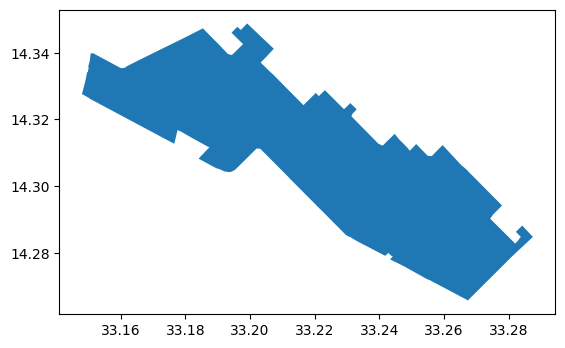

In [79]:
#show shapefile
gdf = gpd.read_file('/content/Wad_Helal.shp')
# Plotting the area
gdf.plot()
gdf
,

In [80]:
# read shapefile and reference raster files

InputVector = r"/content/Wad_Helal.shp"             # the shapefile of the project
RefImage    = r"/content/sample_res.tif" # Reference raster to fix the the pixel size
OutputImage = r'/content/Wad_Helal_masked'            # name the output raster file
burnVal     = 1                                                         #value for the output image pixels

In [81]:
# A script to rasterise a shapefile to the same projection & pixel resolution as a reference image.
gdalformat = 'GTiff'
datatype = gdal.GDT_Byte


##########################################################
# Get projection info from reference image
Image = gdal.Open(RefImage, gdal.GA_ReadOnly)

# Open Shapefile
Shapefile = ogr.Open(InputVector)
Shapefile_layer = Shapefile.GetLayer()

# Rasterise
print("Rasterising shapefile...")
Output = gdal.GetDriverByName(gdalformat).Create(OutputImage, Image.RasterXSize, Image.RasterYSize, 1, datatype, options=['COMPRESS=LZW'])
Output.SetProjection(Image.GetProjectionRef())
Output.SetGeoTransform(Image.GetGeoTransform())

# Write data to band 1
Band = Output.GetRasterBand(1)
Band.SetNoDataValue(0)
gdal.RasterizeLayer(Output, [1], Shapefile_layer, burn_values=[burnVal])

# Close datasets
Band = None
Output = None
Image = None
Shapefile = None

# Build image overviews
subprocess.call("gdaladdo --config COMPRESS_OVERVIEW DEFLATE "+OutputImage+" 2 4 8 16 32 64", shell=True)
print("Done.")

Rasterising shapefile...
Done.


In [82]:
OutputImage

'/content/Wad_Helal_masked'

## i) Import the resampled input data

In [83]:

# reference evapotranspiration and precipitation


input_folderPCP  = '/content/content/resampled/L1-PCP-E_resampled'
input_fhsPCP     = glob.glob(input_folderPCP + '/*.tif')

input_folderRET  = '/content/content/resampled/L1-RET-E_resampled'
input_fhsRET     = glob.glob(input_folderRET + '/*.tif')

ProArea = gis.OpenAsArray(r'/content/Wad_Helal_masked', nan_values=True)  # the project boundary/area (tif)
input_fhsPCP

['/content/content/resampled/L1-PCP-E_resampled/bb_L1-PCP-E_NONE_day_2022-01-14.tif',
 '/content/content/resampled/L1-PCP-E_resampled/bb_L1-PCP-E_NONE_day_2022-01-11.tif',
 '/content/content/resampled/L1-PCP-E_resampled/bb_L1-PCP-E_NONE_day_2022-01-06.tif',
 '/content/content/resampled/L1-PCP-E_resampled/bb_L1-PCP-E_NONE_day_2022-01-17.tif',
 '/content/content/resampled/L1-PCP-E_resampled/bb_L1-PCP-E_NONE_day_2022-01-07.tif',
 '/content/content/resampled/L1-PCP-E_resampled/bb_L1-PCP-E_NONE_day_2022-01-24.tif',
 '/content/content/resampled/L1-PCP-E_resampled/bb_L1-PCP-E_NONE_day_2022-01-16.tif',
 '/content/content/resampled/L1-PCP-E_resampled/bb_L1-PCP-E_NONE_day_2022-01-29.tif',
 '/content/content/resampled/L1-PCP-E_resampled/bb_L1-PCP-E_NONE_day_2022-01-02.tif',
 '/content/content/resampled/L1-PCP-E_resampled/bb_L1-PCP-E_NONE_day_2022-01-25.tif',
 '/content/content/resampled/L1-PCP-E_resampled/bb_L1-PCP-E_NONE_day_2022-01-19.tif',
 '/content/content/resampled/L1-PCP-E_resampled/bb_L1-

## ii) Output folder: Make one or connect to the existing one

In [106]:
output_folderPCP    = '/content/content/filtered/L1-PCP-E_filtered'
output_folderRET  = '/content/content/filtered/L1-RET-E_filtered'


## Make one if the folder does not exit
if not os.path.exists(output_folderRET):
    os.makedirs(output_folderRET)
if not os.path.exists(output_folderPCP):
    os.makedirs(output_folderPCP)

output_folderPCP, output_folderRET

('/content/content/filtered/L1-PCP-E_filtered',
 '/content/content/filtered/L1-RET-E_filtered')

#### Plot project area

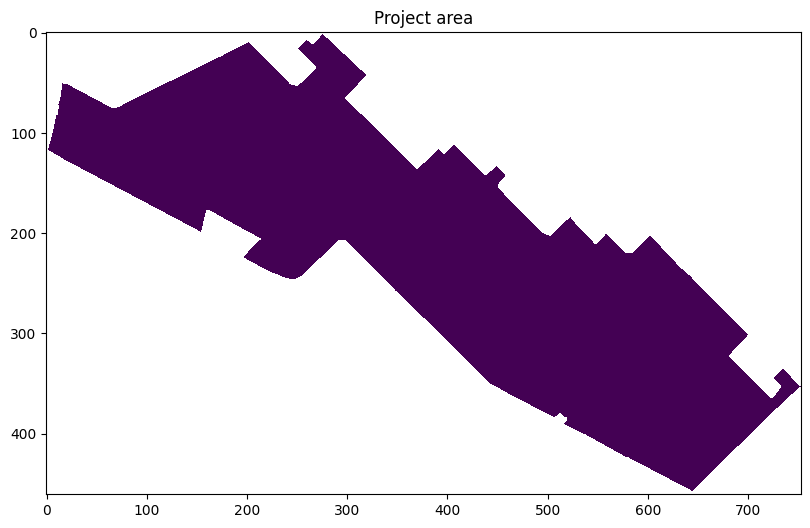

In [107]:
### Plot project area
Projectboundary = ProArea

# Plot
plt.figure(figsize = (12,6))
plt.imshow(Projectboundary)
plt.title('Project area')
plt.show();

###Filtering Precipitation layers

#### Check precipitation raster layer (before clipping to the project area)

In [108]:
input_fhsPCP[0]

'/content/content/resampled/L1-PCP-E_resampled/bb_L1-PCP-E_NONE_day_2022-01-14.tif'

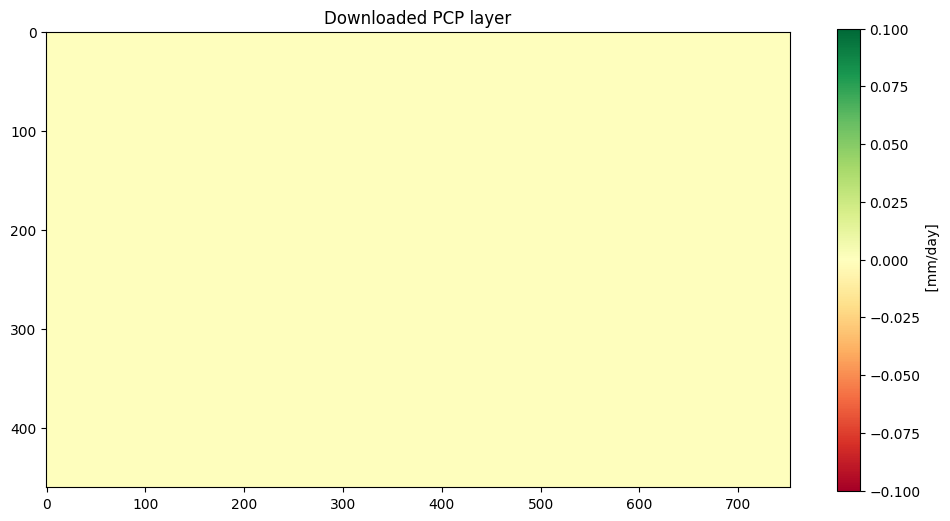

In [109]:
# Plot PCP layer
PCP_tif = gis.OpenAsArray(input_fhsPCP[0],nan_values=True)

plt.figure(figsize = (12,8))
plt.imshow(PCP_tif, cmap='RdYlGn')
plt.colorbar(shrink=0.75, label=' [mm/day]')
plt.title('Downloaded PCP layer')
plt.show()

####Filtering Precipitation layers



In [110]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsPCP[0]
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

for PCPfh in input_fhsPCP:
    PCP = gis.OpenAsArray(PCPfh, nan_values=True)
    PCP   = np.where((ProArea==1),PCP,np.nan)

    # update the file name, and save into output folder
    basename  = os.path.basename(PCPfh)
    output_fn = os.path.join(output_folderPCP, basename)
    gis.CreateGeoTiff(output_fn, PCP, driver, NDV, xsize, ysize, GeoT, Projection)

#### Check precipitation raster layer (after clipping to the project area)




In [112]:
output_fhsPCP = glob.glob(output_folderPCP + '/*.tif')
output_fhsPCP[0]

'/content/content/filtered/L1-PCP-E_filtered/bb_L1-PCP-E_NONE_day_2022-01-14.tif'

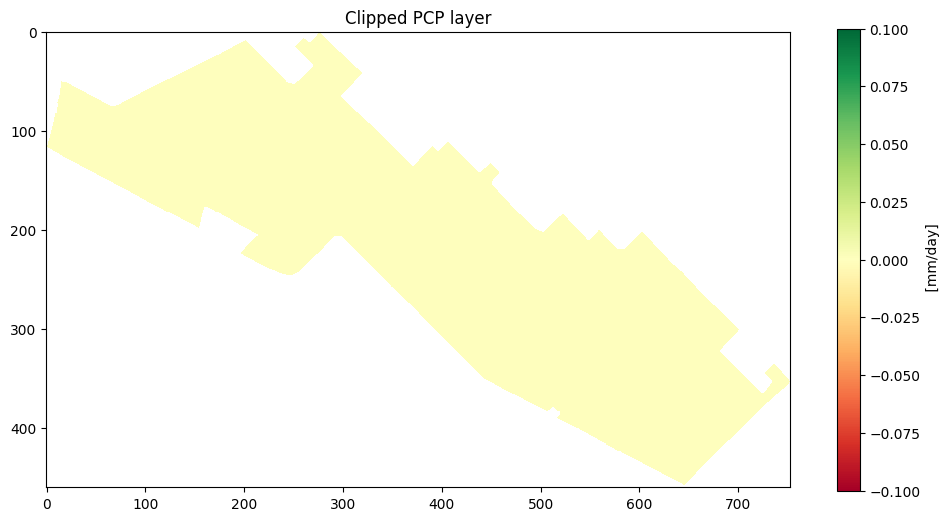

In [114]:
#visualise the raster output
#input_folderPCPfil  = '/content/content/filtered/L1-RET-E_filtered'
output_fhsPCP     = glob.glob(output_folderPCP + '/*.tif')
PCP_tif = gis.OpenAsArray(output_fhsPCP[0],nan_values=True)      # Path to seasonal file
plt.figure(figsize = (12,8))
plt.imshow(PCP_tif, cmap='RdYlGn')
plt.colorbar(shrink=0.75, label=' [mm/day]')
plt.title('Clipped PCP layer')
plt.show()

###Filtering Reference ET layers

In [94]:
input_fhsRET[50]

'/content/content/resampled/L1-RET-E_resampled/bb_L1-RET-E_NONE_day_2022-01-02.tif'

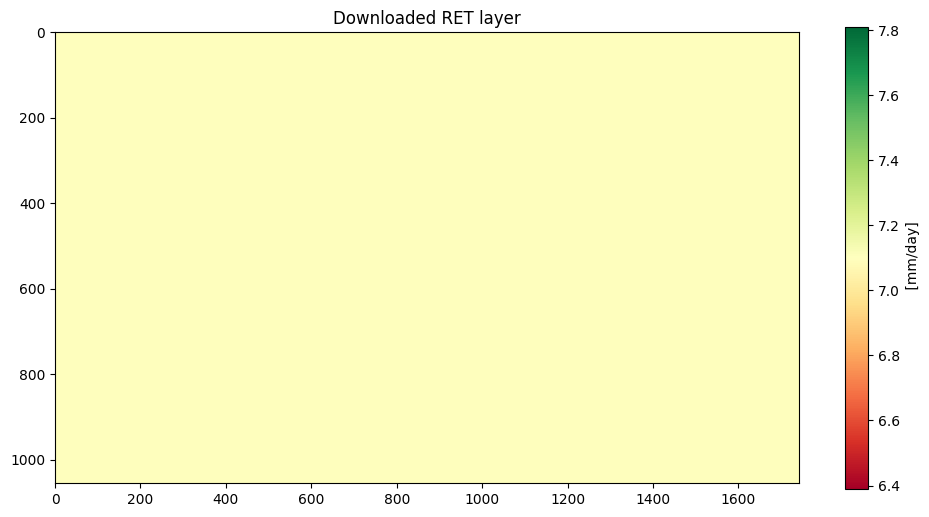

In [96]:
# Plot RET layer to check values
RET_tif = gis.OpenAsArray(input_fhsRET[50],nan_values=True)

plt.figure(figsize = (12,8))
plt.imshow(RET_tif, cmap='RdYlGn')
plt.colorbar(shrink=0.75, label=' [mm/day]')
plt.title('Downloaded RET layer')
plt.show()

####Filtering Reference ET Layers

In [ ]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsRET[0]
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

for RETfh in input_fhsRET:
    RET = gis.OpenAsArray(RETfh, nan_values=True)
    RET   = np.where((ProArea==1),RET,np.nan)

    # update the file name, and save into output folder
    basename  = os.path.basename(EETfh)
    output_fn = os.path.join(output_folderRET, basename)
    gis.CreateGeoTiff(output_fn, RET, driver, NDV, xsize, ysize, GeoT, Projection)

#### Check reference ET raster layer (after clipping to the project area)

In [ ]:
#visualise the raster output

output_fhsRET     = glob.glob(output_folderRET + '/*.tif')
RET_tif = gis.OpenAsArray(output_fhsRET[0],nan_values=True)      # Path to seasonal file
plt.figure(figsize = (12,8))
plt.imshow(RET_tif, cmap='RdYlGn')
plt.colorbar(shrink=0.75, label=' [mm/day]')
plt.title('Clipped RET layer')
plt.show()

# Step d - Create seasonal climate layers


Create output folders

In [124]:
output_folderPCP_season = "/content/content/PCP_season"
output_folderRET_season = "/content/content/RET_season"

if not os.path.exists(output_folderPCP_season):
    os.makedirs(output_folderPCP_season)
output_folderPCP_season

if not os.path.exists(output_folderRET_season):
    os.makedirs(output_folderRET_season)
output_folderRET_season

'/content/content/RET_season'

Define seasons

In [133]:
season_periods = {
    'season1': {'SOS': '2022-10-01', 'EOS': '2023-04-30'}
}

###Define function for temporal aggregation

This script defines the function `SumSeason `which is used in the next sections. Using functions in such a way improves the readability and replicability of the scripts and avoids errors. For example we need this function to aggregate AETI and NPP data.

Review this script, main difference compared to the script you used in the previous Notebook is that this script uses the metadata of the files to identify the dates. Disadvantage is that it requires opening and closing of each file and could take time when working with a lot of data. The script also considers part of dekadal values when start or end date is in the middle of the dekad (part of the if-statements).

In [135]:
# summation of raster between two dates
def SumSeason(input_fhs, sowing_date, harvesting_date):

    # add rasters that falls within sowing and harvesting date
    Sums = 0
    for i, in_fh in enumerate(input_fhs):
        # open raster file and get start and end date from attributes
        ds = rioxr.open_rasterio(in_fh)
        ds = ds.where(ds!=ds.attrs['_FillValue'])
        if i == 0:
          attrs = ds.attrs
        raster_startdate = datetime.datetime.strptime(ds.attrs['start_date'], '%Y-%m-%d' ).date()
        raster_enddate   = datetime.datetime.strptime(ds.attrs['end_date'], '%Y-%m-%d' ).date()

        # accumulate full or part of the dekadal value
        if (raster_startdate >= sowing_date) & (raster_enddate <= harvesting_date):
            Sum = ds
            Sums += Sum
#             print ("1",in_fh)

        elif (raster_startdate <sowing_date)&(raster_enddate >sowing_date)&(raster_enddate <harvesting_date):
            Sum = ds
            Sum = Sum*((raster_enddate-sowing_date)/(raster_enddate-raster_startdate))
            Sums += Sum
#             print ("2",in_fh)

        elif (raster_startdate >sowing_date)&(raster_startdate <harvesting_date)&(raster_enddate >harvesting_date):
            Sum = ds
            Sum = Sum*((harvesting_date- raster_startdate)/(raster_enddate-raster_startdate))
            Sums += Sum
#             print ("3",in_fh)

        elif (sowing_date>=raster_startdate)&(harvesting_date<=raster_enddate):
            Sum = ds
            Sum = Sum*((harvesting_date- sowing_date)/(raster_enddate-raster_startdate))
            Sums += Sum
#             print ("4",in_fh)
    attrs.update({'start_date':datetime.datetime.strftime(SOS, '%Y-%m-%d'),
              'end_date': datetime.datetime.strftime(EOS, '%Y-%m-%d'),
              'units' : 'mm/season'})
    del attrs['number_of_days']
    del attrs['temporal_resolution']
    del attrs['units_conversion_factor']

    Sums.attrs  = attrs
    return Sums

Calculate seasonal **PCP**

In [136]:
# Assign inputs to the SumSeason function
input_fhs      = output_fhsPCP
output_folder  = output_folderPCP_season


for i, season in enumerate(season_periods):
    # calculate the seasonal value and save in output_folder
    SOS = datetime.datetime.strptime(season_periods[season]['SOS'],'%Y-%m-%d').date()
    EOS = datetime.datetime.strptime(season_periods[season]['EOS'],'%Y-%m-%d').date()
    seasonal = SumSeason(input_fhs, SOS, EOS)

    ## save the array in raster format, name it with the raster_id and sowing and harvesting date
    out_fh = os.path.join(output_folder, 'PCP' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    seasonal.rio.to_raster(out_fh)

    # calculate the mean, SD
    print ('the mean, SD for ', season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))

    # Plot the raster map
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='PCP [mm/season]')
    plt.xlabel('Longitude [m]', fontsize=14)  # add axes label
    plt.ylabel('Latitude [m]', fontsize=14)
    plt.title('PCP [mm/season] ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], fontsize=16)
    plt.clim()
    plt.show ();

KeyError: 'start_date'

Calculate seasonal **Reference ET**

In [ ]:
# Assign inputs to the SumSeason function
input_fhs      = output_fhsRET
output_folder  = output_folderRET_season


for i, season in enumerate(season_periods):
    # calculate the seasonal value and save in output_folder
    SOS = datetime.datetime.strptime(season_periods[season]['SOS'],'%Y-%m-%d').date()
    EOS = datetime.datetime.strptime(season_periods[season]['EOS'],'%Y-%m-%d').date()
    seasonal = SumSeason(input_fhs, SOS, EOS)

    ## save the array in raster format, name it with the raster_id and sowing and harvesting date
    out_fh = os.path.join(output_folder, 'RET' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    seasonal.rio.to_raster(out_fh)

    # calculate the mean, SD
    print ('the mean, SD for ', season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))

    # Plot the raster map
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='RET [mm/season]')
    plt.xlabel('Longitude [m]', fontsize=14)  # add axes label
    plt.ylabel('Latitude [m]', fontsize=14)
    plt.title('RET [mm/season] ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'], fontsize=16)
    plt.clim()
    plt.show ();

# Step e - Create Potential ET layer






## iv) Calculate seasonal ETp(ETc) = Kc*RET

## **** Define and import the Kc per month
* Edit the **months** the corresponding **Kc** value in the order of start of crop season (inital stage) to end of crop season (late-season stage) **in the df_Kc.xlsx file in the data folder**
* The rows should be for months within the duration of the crop season
* The figure below shows the Kc curve of a sugarcane, given as example
![title](https://raw.githubusercontent.com//wateraccounting/WAPORWP/master/Notebooks/img/Fig3_2.PNG)

In [115]:
#To upload boundary shape (and LCC) file.
from google.colab import files
uploaded = files.upload()

Saving df_Kcwheat_wad_helal.xlsx to df_Kcwheat_wad_helal.xlsx


In [120]:

df_kc = pd.read_excel('/content/df_Kcwheat_wad_helal.xlsx')
df_kc

,Months,Kc,Crops stage
0,October,0.725,Initial
1,November,0.925,Initial
2,December,1.125,development
3,January,1.150,mid-season
4,February,1.150,mid-season
5,March,0.650,Late-season
6,April,0.300,Late-season


from matplotlib import pyplot as plt
df_kc['Kc'].plot(kind='hist', bins=20, title='Kc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_kc.groupby('Months').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_kc.groupby('Crops stage').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_kc['Kc'].plot(kind='line', figsize=(8, 4), title='Kc')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Crops stage'].value_counts()
    for x_label, grp in df_kc.groupby('Months')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Months')
_ = plt.ylabel('Crops stage')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_kc['Months'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_kc, x='Kc', y='Months', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_kc['Crops stage'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_kc, x='Kc', y='Crops stage', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

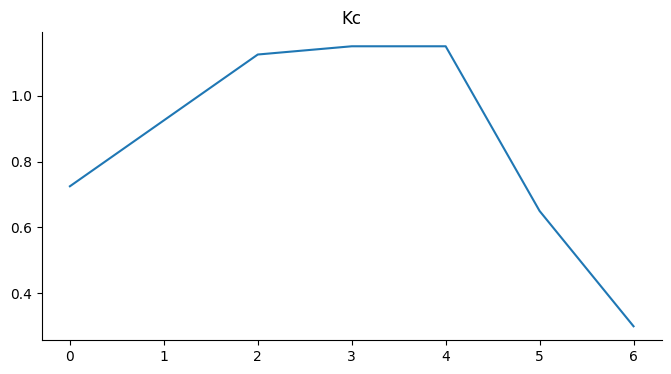

In [122]:
df_kc['Kc'].plot(kind='line', figsize=(8, 4), title='Kc')
plt.gca().spines[['top', 'right']].set_visible(False)

In [119]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = output_fhsRET[0]
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

length = len(df_dates)  # length of season

i = 0
while i < length:
    date_s  = df_dates.SOS[i].date()   # the starting date of the season (SOS)
    #ETc_total[i] = 0
    print ('Monthly ETo, ETc in mm/month and Kc[-] in ', date_s.year)
    seasonal = 0
    while date_s < df_dates.EOS[i].date():    # loop in the range of SOS and EOS of the active season 'i'
        # Increment by a month
        days    = calendar.monthrange(date_s.year,date_s.month)[1] # Number of days in the active month
        date_e  = date_s+datetime.timedelta(days=days-1)           # The end date of the active month

        m = date_s.strftime('%B')         # identify the name of the active month
        kc_m =df_kc.loc[df_kc["Months"] == m, 'Kc'].item()  # identify the kc value corresponding to a month

        # calculate the monthly value and save in output_folder
        ET0 = SumSeason(input_fhsRET, output_folderRET_month, date_s, date_e, df_availRET) # adding reference ET in the active month
        ETc = kc_m*ET0    # calculate monthly ETP (ETc)

        print (date_s.year, m, np.nanmean(ET0).round(1), np.nanmean(ETc).round(1), kc_m)
        date_s  = date_e+datetime.timedelta(days=1)   # First day of the next month
        seasonal+= ETc

    # save the seasonal array in raster format, name it with the raster name, sowing and harvesting date
    out_fh = os.path.join(output_folderETp, 'ETc_' + str(df_dates.SOS[i].date()) + '_to_' + str(df_dates.EOS[i].date()) + '.tif')
    gis.CreateGeoTiff(out_fh, seasonal, driver, NDV, xsize, ysize, GeoT, Projection)  # Save the array 'Sums' as raster
    print ('The mean seasonal ETc [mm] in ', date_s.year, ' is ', np.nanmean(seasonal).round(1))

    # Plot the raster map
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='ETc=Kc*ETo [mm/season]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=12)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=12)
    plt.title('ETc ' + str(df_dates.SOS[i].date()) + '/' + str(df_dates.EOS[i].date()), fontsize=12)
    plt.clim()
    plt.show ()

    i += 1
    ;

NameError: name 'output_fhsRET' is not defined